# Tutorial PAMAP2 with mcfly

The goal of this tutorial is to get you familiar with training Neural Networks for time series using mcfly. At the end of the tutorial, you will have compared several Neural Network architectures you know how to train the best performing network.

As an example dataset we use the publicly available [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring). It contains time series data from movement sensors worn by nine individuals. The data is labelled with the activity types that these individuals did and the aim is to train and evaluate a *classifier*.

Before you can start, please make sure you install mcfly (see the [mcfly installation page](https://github.com/NLeSC/mcfly)).

## Import required Python modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
# mcfly
from mcfly import modelgen, find_architecture, storage
from keras.models import load_model
np.random.seed(2)

Using TensorFlow backend.


In [2]:
sys.path.insert(0, os.path.abspath('../..'))
from utils import tutorial_pamap2

## Download data pre-procesed data

We have created a function for you to fetch the preprocessed data from https://zenodo.org/record/834467. Please specify the `directory_to_extract_to` in the code below and then execute the cell. This will download the preprocessed data into the directory in the `data` subdirectory. The output of the function is the path where the preprocessed data was stored.

In [3]:
# Specify in which directory you want to store the data:
directory_to_extract_to = "C:\\Users\FlorianHuber\\OneDrive - Netherlands eScience Center\\Project_mcfly\\mcfly-tutorial"

In [5]:
data_path = tutorial_pamap2.download_preprocessed_data(directory_to_extract_to)

Data already downloaded
Extracting data...
Done


## A bit about the data

The [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring) contains data from three movement sensors worn by nine test subjects. These subjects performed a protocol of several activities.

The data originates from three sensors (on the hand, ankle and chest) and from each of the sensors we have three channels (acceleration on x, y and z axes). This gives us, for each time step, 9 values. The data is recorded at 100 Hz.

The preprocessed data is split into smaller segments with a window of 512 time steps, corresponding to 5.12 seconds. We only include segments that completely fall into one activity period: the activity is the *label* of the segment.

The goal of classification is to assign an activity label to an previously unseen segment.

## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files. Please note that the data has already been split up in a training (training), validation (val), and test subsets. It is common practice to call the input data X and the labels y.

In [6]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary, labels = tutorial_pamap2.load_data(data_path)

Data X and labels y are of type Numpy array. <br>
In the cell below we inspect the shape of the data. As you can see the shape of X is expressed as a Python tuple containing: the number of samples, length of the time series, and the number of channels for each sample. Similarly, the shape of y represents the number of samples and the number of classes (unique labels). Note that y has the format of a binary array where only the correct class for each sample is assigned a 1. This is called one-hot-encoding.

In [7]:
print('x shape:', X_train.shape)
print('y shape:', y_train_binary.shape)

x shape: (11397, 512, 9)
y shape: (11397, 7)


The data is split between train, test, and validation.

In [8]:
print('train set size:', X_train.shape[0])
print('validation set size:', X_val.shape[0])
print('test set size:', X_test.shape[0])

train set size: 11397
validation set size: 100
test set size: 1000


Let's have a look at the distribution of the labels:

In [9]:
frequencies = y_train_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
lying,0.136615
sitting,0.130736
standing,0.136703
walking,0.176625
cycling,0.118540
vaccuum_cleaning,0.125208
ironing,0.175573


### *Question 1: How many channels does this dataset have?*
### *Question 2: What is the least common activity label in this dataset?*

    

## Generate models

First step in the development of any deep learning model is to create a model architecture. <br> As we do not know what architecture is best for our data we will create a set of random models to investigate which architecture is most suitable for our data and classification task. This process, creating random models, checking how good they are and then selecting the best one is called a _'random search'_. A random search is considered to be the most robust approach to finding a good model. You will need to specificy how many models you want to create with argument 'number_of_models'. For a full overview of the optional arguments see the function documentation of modelgen.generate_models by running `modelgen.generate_models?`.

##### What number of models to select?
This number differs per dataset. More models will give better results but it will take longer to evaluate them. For the purpose of this tutorial we recommend trying only 2 models to begin with. If you have enough time you can try a larger number of models, e.g. 10 or 20 models. Because mcfly uses random search, you will get better results when using more models.

In [10]:
num_classes = y_train_binary.shape[1]

models = modelgen.generate_models(X_train.shape,
                                  number_of_classes=num_classes,
                                  number_of_models = 5)

# Inspect the models
We can have a look at the models that were generated. <br>
Running `model_visualization.model_overview` allows to compare the generated models. This simplified graphical representations will display the different layers of the models. Most common layer types are 1D or 2D convolutional layers (_Conv1D_, _Conv2D_), batch normalization layers (_BatchNorm_), or ReLu activation layers (_relu_).
For more information see the [mcfly user manual](https://github.com/NLeSC/mcfly/wiki/User-manual) and the [tutorial cheat sheet](https://github.com/NLeSC/mcfly-tutorial/blob/master/cheatsheet.md). 

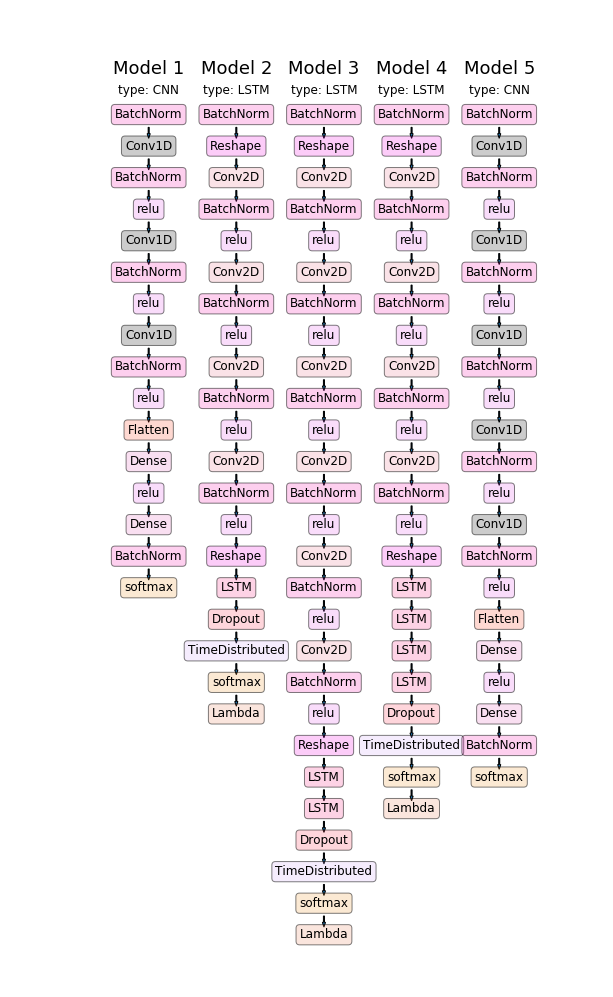

In [21]:
#from mcfly import model_overview
from model_visualization import model_overview

model_overview(models, 
                   max_num_models=5, 
                   scale_figwidth=10,
                   scale_boxes=1.2, 
                   file_figure = None, #"model_comparison.png",
                   extra_layer_info=False)

##### More detailed output of model parameters
Besides the graphical overview of the generated models it is also possible to access all model layers and paramters in more detail. <br>
Here, the layers are shown as table rows.
The summary also shows the data shape of each layer output and the number of parameters that are trained within this layer.

In [22]:
models_to_print = range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i) + " (model type: " + model_types + ")")
        print(" ")
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0 (model type: CNN)
 
Hyperparameters:
{'learning_rate': 0.08360289270402858, 'regularization_rate': 0.0022439468517196116, 'filters': array([85, 17, 44]), 'fc_hidden_nodes': 443}
 
Model description:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 512, 9)            36        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 85)           2380      
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 85)           340       
_________________________________________________________________
activation_1 (Activation)    (None, 512, 85)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            

### *Question 3: Can you guess what hyperparameter 'learning rate' stands for?*

## Compare models
Now that the model architectures have been generated it is time to compare the models by training them on a subset of the training data and evaluating the models on the validation subset. This will help us to choose the best candidate model. The performance results for the models are stored in a json file, which we will visually inspect later on.

In [23]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(directory_to_extract_to, 'data/models')
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

We are now going to train each of the models that we generated. On the one hand we want to train them as quickly as possible in order to be able to pick the best one as soon as possible. On the other hand we have to train each model long enough to get a good impression of its potential.

We can influence the train time by adjusting the number of data samples that are used. This can be set with the argument 'subset_size'. We can also adjust the number of times the subset is iterated over. This number is called an epoch. We recommend to start with no more than 5 epochs and a maximum subset size of 300. You can experiment with these numbers.

In [24]:
outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                           X_val, y_val_binary,
                                                                           models,nr_epochs=5,
                                                                           subset_size=300,
                                                                           verbose=True,
                                                                           outputfile=outputfile)
print('Details of the training process were stored in ',outputfile)

Training model 0 CNN
Train on 300 samples, validate on 100 samples
Epoch 1/5
300/300 [==============================] - 6s 21ms/step - loss: 555.3925 - acc: 0.5067 - val_loss: 427.0047 - val_acc: 0.3000
Epoch 2/5
300/300 [==============================] - 3s 12ms/step - loss: 209.4111 - acc: 0.6400 - val_loss: 73.6920 - val_acc: 0.3000
Epoch 3/5
300/300 [==============================] - 3s 12ms/step - loss: 40.0332 - acc: 0.6300 - val_loss: 20.5533 - val_acc: 0.1300
Epoch 4/5
300/300 [==============================] - 4s 12ms/step - loss: 11.7653 - acc: 0.6500 - val_loss: 7.8834 - val_acc: 0.2500
Epoch 5/5
300/300 [==============================] - 5s 15ms/step - loss: 5.1938 - acc: 0.6333 - val_loss: 5.3296 - val_acc: 0.3300
Training model 1 DeepConvLSTM
Train on 300 samples, validate on 100 samples
Epoch 1/5
300/300 [==============================] - 52s 172ms/step - loss: 2.3719 - acc: 0.3900 - val_loss: 1.7202 - val_acc: 0.7400
Epoch 2/5
300/300 [==============================] - 

### *Question 4: What do the terms 'acc' and 'loss' in the output refer to?*

# Inspect model performance (Visualization)

We can inspect the learning process in the visualization tool on http://nlesc.github.io/mcfly/.

Alternatively, you can run the visualization from a local web service:
- Clone the mcfly github repository (if you haven't done so already for visualization)

 `git clone https://github.com/NLeSC/mcfly`


- navigate to the html folder:

 `cd mcfly/html`


- Start a web server. This can be done in various ways, for example:
 - for python 3 you can use: `python3 -m http.server`
 - for python 2 you can use: `python2 -m SimpleHTTPServer`

Notice the port number the web server is serving on. This is usually 8000.
With a web browser, navigate to [localhost:8000](localhost:8000). 

You need to upload the json file that contains the details of the training process. The following line of code shows the path to this file:

In [25]:
outputfile

'C:\\Users\\FlorianHuber\\OneDrive - Netherlands eScience Center\\Project_mcfly\\mcfly-tutorial\\data/models\\modelcomparison.json'

### *Question 5:  Look at the visualization. Which model performs best?*
### *Question 6:  Did you train all models with a sufficient number of iterations?*

# Inspect model performance (table)

Let's compare the performance of the models by showing the results as a table.

In [26]:
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons.to_csv(os.path.join(resultpath, 'modelcomparisons.csv'))

modelcomparisons

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 0.08360289270402858, 'regula...",0.633333,5.193790,0.33,5.329594
1,"{'learning_rate': 0.000893145093504032, 'regul...",0.740000,1.560198,0.80,1.325806
2,"{'learning_rate': 0.0045162313812273, 'regular...",0.726667,0.900497,0.75,0.863687
3,"{'learning_rate': 0.00011922953164184091, 'reg...",0.623333,2.088891,0.56,2.003892
4,"{'learning_rate': 0.0010358940660228366, 'regu...",0.913333,6.518415,0.37,6.950583


# Choose the best model
Now that we found an effective architecture, we can choose the most promising model. For example, we can choose the model with the highest accuracy on the validation data set. To maximize this models performance, we will train this model on more data and more epochs.

In [27]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print('Model type and parameters of the best model:')
print(best_model_types)
print(best_params)

Model type and parameters of the best model:
DeepConvLSTM
{'learning_rate': 0.000893145093504032, 'regularization_rate': 0.00319386451934688, 'filters': [48, 43, 68, 77], 'lstm_dims': [78]}


## Train the best model on the full dataset

Now that we have identified the best model architecture out of our random pool of models we can continue by training the model on the full training set.

This would take some time, so instead we will train  on only a slightly larger subset.

In [28]:
#We make a copy of the model, to start training from fresh
nr_epochs = 2
datasize = 2500 # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 2500 samples, validate on 100 samples
Epoch 1/2
2500/2500 [==============================] - 389s 156ms/step - loss: 1.2788 - acc: 0.8344 - val_loss: 1.0643 - val_acc: 0.8800
Epoch 2/2
2500/2500 [==============================] - 395s 158ms/step - loss: 1.1378 - acc: 0.8636 - val_loss: 1.0128 - val_acc: 0.8900


### *Question 7: Why does it take longer to train the best model for one epoch now than when we were  comparing model archicatures earlier on?*

### *Question 8: Do you think it is useful to train with more than 1 epoch?*

### Saving, loading and comparing reloaded model with original model

The model can be saved for future use. The savemodel function will save two separate files: a json file for the architecture and a npy (numpy array) file for the weights.

In [29]:
modelname = 'my_bestmodel.h5'
model_path = os.path.join(resultpath,modelname)

In [30]:
best_model.save(model_path)

In [31]:
model_reloaded = load_model(model_path)

The model has been reloaded. Let's reassure that this model has the same weights

In [32]:
np.all([np.all(x==y) for x,y in zip(best_model.get_weights(), model_reloaded.get_weights())])

True

## Investigate model predictions

We will now dive further into the Neural network that we created.
We provide here a network that has been trained on the complete train set.

In [35]:
os.path.isfile('./model/model.h5')

True

In [36]:
if os.path.isfile('./model/model.h5'): 
    model = load_model('./model/model.h5')

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Note that the objects `models`, `best_model_fullytrained` and `best_model` that resulted from the mcfly functions are Keras objects. This means that you can use Keras functions on the objects, for example  `.predict`, (which when given the data, outputs the predictions for each sample) and `.evaluate` (which when given the data and the labels computes how well this model performs) . These functions are all documented in the [Keras documentation](https://keras.io/). 

In [37]:
## Inspect model predictions on validation data
datasize = X_val.shape[0]
probs = best_model.predict_proba(X_val[:datasize,:,:],batch_size=1)

Let's have a look at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [38]:
#columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
y_index = y_val_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,lying,sitting,standing,walking,cycling,vaccuum_cleaning,ironing
lying,13,0,0,0,0,0,0
sitting,0,13,1,0,0,0,0
standing,0,1,18,0,0,0,1
walking,0,1,0,14,0,0,0
cycling,0,0,0,0,12,0,0
vaccuum_cleaning,0,0,0,0,0,6,2
ironing,0,5,0,0,0,0,13


In [39]:
## Test on Testset
score_test = best_model.evaluate(X_test, y_test_binary, verbose=True)
print('Score of best model: ' + str(score_test))

1000/1000 [==============================] - 34s 34ms/step
Score of best model: [0.9711083784103394, 0.931]
